# EMA Analyses

Kendra Wyant

In [ ]:
#|echo: FALSE

# handle conflicts
options(conflicts.policy = "depends.ok")
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/fun_ml.R?raw=true")

ℹ SHA-1 hash of file is "77e91675366f10788c6bcb59fa1cfc9ee0c75281"

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──
✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.9     
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org

ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

### Posterior Probabilities

In [ ]:
#| echo: false
#| output: false
path_models_fyp <- format_path("studydata/risk/models/meta/")

model_fits_fyp <- read_csv(file.path(path_models_fyp, "best_model_fits_1hour_0_v2_10_x_10_kfold_fyp.csv"), col_types = cols()) |> 
  select(id = n_repeat, id2 = n_fold, best_model = roc_auc) |> 
  mutate(null_model = .5)

set.seed(101)
pp_fyp <- model_fits_fyp |> 
  perf_mod(formula = statistic ~ model + (1 | id2/id),
           transform = tidyposterior::logit_trans,  # for skewed & bounded AUC
           iter = 2000, chains = 4,  
           adapt_delta = .99,
           family = gaussian) 


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 6.6e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.631 seconds (Warm-up)
Chain 1:                1.143 seconds (Sampling)
Chain 1:                2.77

In [ ]:
#| echo: false

pp_fyp_tidy <- pp_fyp |> 
  tidy(seed = 123)

ci_fyp <- pp_fyp_tidy |> 
  summary() |> 
  mutate(model = factor(model, 
                        levels = c("best_model", "null_model"),
                        labels = c("Main", "Null")),
         y = 750)

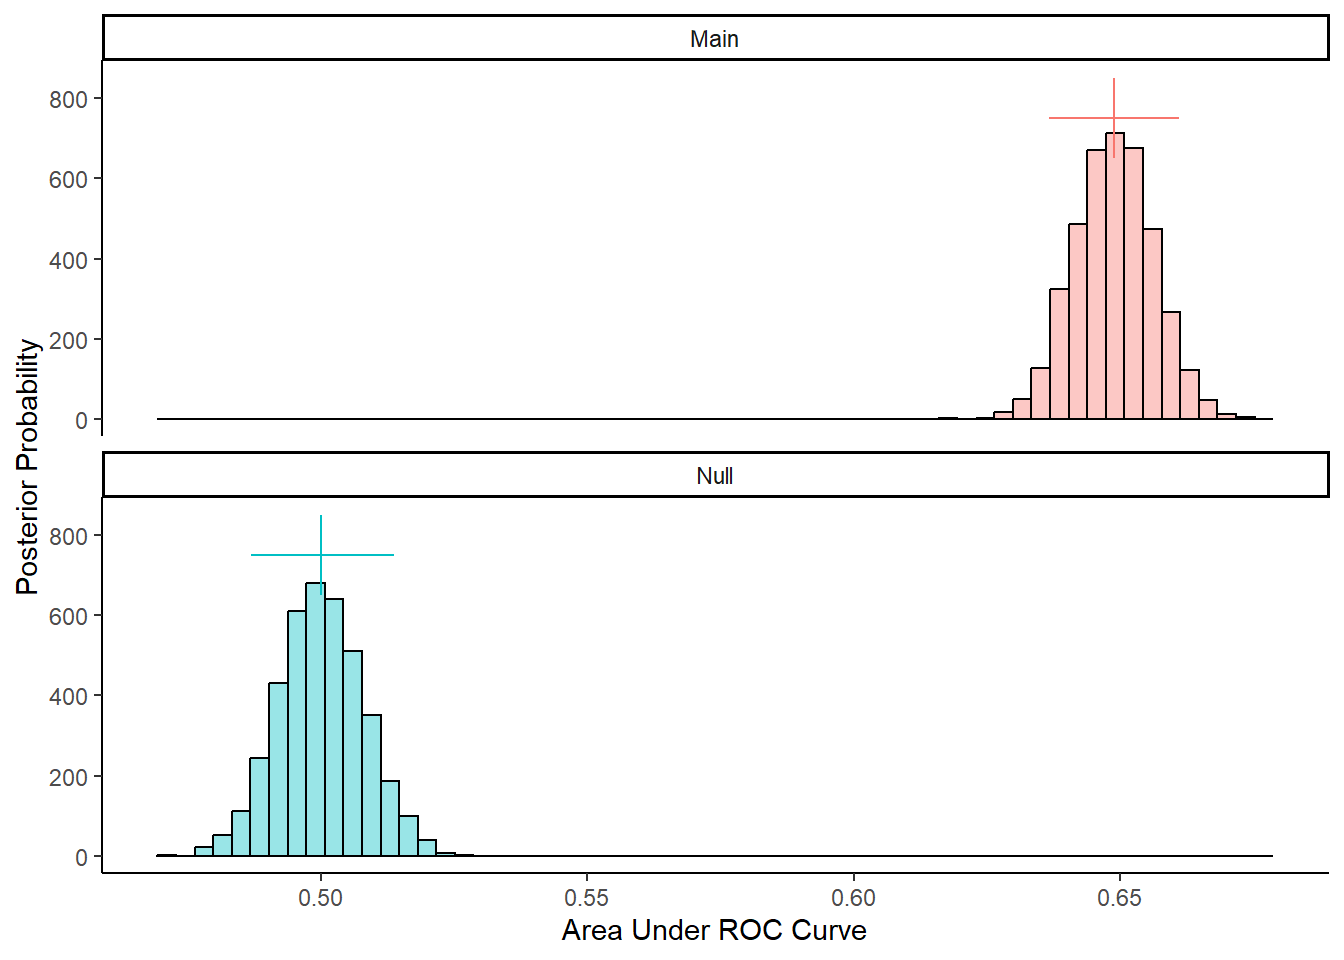

In [ ]:
#| label: fig-fyp-posteriors

pp_fyp_tidy |> 
  mutate(model = factor(model, 
                        levels = c("best_model", "null_model"),
                        labels = c("Main", "Null"))) |>
  ggplot() + 
  geom_histogram(aes(x = posterior, fill = model), color = "black", alpha = .4, 
                 bins = 60) +
  geom_segment(mapping = aes(y = y+100, yend = y-100, x = mean, xend = mean,
                           color = model),
               data = ci_fyp) +
  geom_segment(mapping = aes(y = y, yend = y, x = lower, xend = upper, color = model),
                data = ci_fyp) +
  facet_wrap(~model, ncol = 1) +
  scale_y_continuous("Posterior Probability") +
  scale_x_continuous("Area Under ROC Curve") +
  theme(legend.position = "none")
  # geom_text(aes(c("Median = 0.90", "Median = 0.91", "Median = .93")))

### Model Contrasts

In [ ]:
ci_fyp <- pp_fyp |>
  contrast_models(list("best_model"), 
                  list("null_model")) |> 
  summary(size = .01) |> 
  mutate(contrast = factor(contrast, 
                        levels = c("best_model vs null_model"),
                        labels = c("Main vs. Null")),
         y = 550)

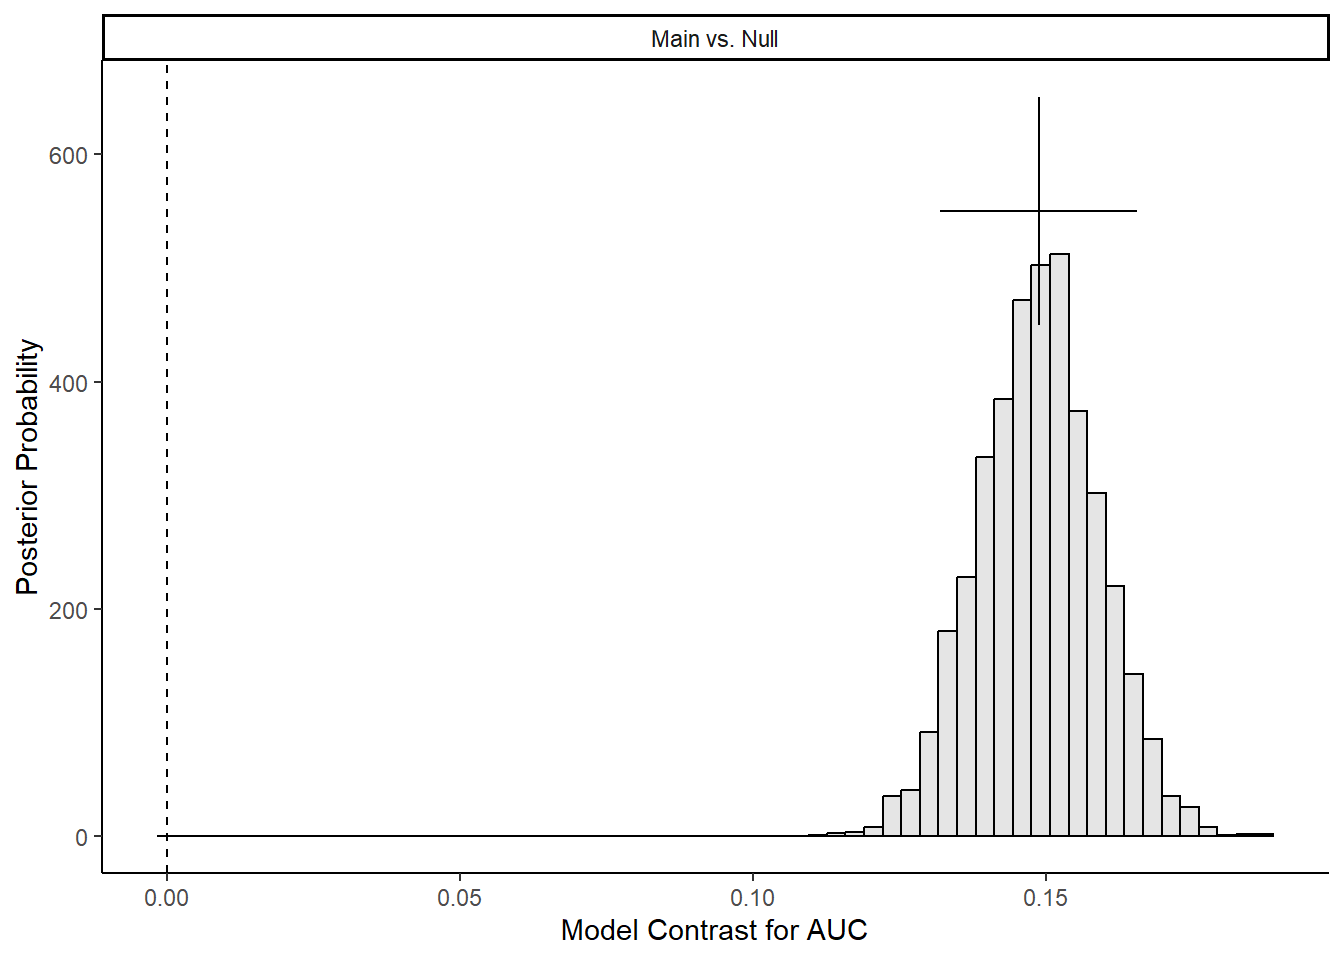

In [ ]:
#| label: fig-fyp-contrasts

pp_fyp |> 
  tidy(seed = 123) |>   
  group_by(model) |> 
  mutate(sample = row_number()) |> 
  ungroup() |> 
  pivot_wider(names_from = model, values_from = posterior) |> 
  mutate("Main vs. Null" = best_model - null_model) |> 
  pivot_longer(cols = "Main vs. Null",
               names_to = "contrast",
               values_to = "posterior") |> 
  mutate(contrast = factor(contrast, 
                           levels = c("Main vs. Null"))) |> 
  ggplot() +
  geom_histogram(aes(x = posterior), 
                 color = "black", fill = "grey", alpha = .4, bins = 60) +
  geom_vline(xintercept = 0, linetype = "dashed") +
  geom_segment(mapping = aes(y = y+100, yend = y-100, x = mean, xend = mean), color = "black", data = ci_fyp) +
  geom_segment(mapping = aes(y = y, yend = y, x = lower, xend = upper), color = "black", data = ci_fyp) +
  facet_wrap(~contrast) +
  ylab("Posterior Probability") +
  xlab("Model Contrast for AUC") +
  theme(legend.position = "none") 